In [372]:
#import classes
from random import shuffle
import gensim
import os
import collections
import smart_open
import random
import re
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [365]:
def read_labels(fname, nums=False):
    arr = []
    with smart_open.smart_open(fname) as f:
        for line in enumerate(f):
            s = line[1].decode('utf-8')
            if nums:
                yield line[1].decode('utf-8')
            else:
                if "UNK" in s:
                    yield 3
                elif "NON" in s:
                    yield 2
                elif "PAST" in s:
                    yield 1
                else:
                    yield 0

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    sns.heatmap(cm)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [342]:
train_nums = list(read_labels("labels-train.txt"))
test_nums = list(read_labels("labels-test.txt"))
train_labels = list(read_labels("labels-train.txt", nums=True))
test_labels = list(read_labels("labels-test.txt", nums=True))

In [343]:
def read_corpus(fname, tokens_only=False):
    with smart_open.smart_open(fname, encoding="iso-8859-1") as f:
        for i, line in enumerate(f):
            if tokens_only:
                yield gensim.utils.simple_preprocess(line)
            else:
                # For training data, add tags
                yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(line), [i])

In [344]:
train_corpus = list(read_corpus("smoking-train.txt"))
test_corpus = list(read_corpus("smoking-test.txt",tokens_only=True))
model = gensim.models.doc2vec.Doc2Vec(size=100, min_count=2, iter=55, dm=0)
model.build_vocab(train_corpus)
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=100)

CPU times: user 49.7 s, sys: 828 ms, total: 50.5 s
Wall time: 21.6 s


22379422

In [366]:
train_vecs = model.docvecs
test_vecs = []
for elem in test_corpus:
    a = list(model.infer_vector(elem))
    test_vecs.append(a)

In [346]:
import xgboost as xgb
import scipy.sparse
import numpy as np
from sklearn.calibration import CalibratedClassifierCV

In [347]:
xg_train = xgb.DMatrix(train_vecs, label=train_nums)
xg_test = xgb.DMatrix(test_vecs, label=test_nums)


In [367]:
# setup parameters for xgboost
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['max_depth'] = 6
param['silent'] = 0
param['num_class'] = 4
print(param)

{'objective': 'multi:softmax', 'max_depth': 6, 'silent': 0, 'num_class': 4}


[0]	train-merror:0.067347	test-merror:0.217822
[1]	train-merror:0.026531	test-merror:0.19802
[2]	train-merror:0.008163	test-merror:0.19802
[3]	train-merror:0.004082	test-merror:0.178218
[4]	train-merror:0	test-merror:0.138614
[5]	train-merror:0	test-merror:0.128713
[6]	train-merror:0	test-merror:0.118812
[7]	train-merror:0	test-merror:0.079208
[8]	train-merror:0	test-merror:0.089109
[9]	train-merror:0	test-merror:0.089109
[10]	train-merror:0	test-merror:0.089109
[11]	train-merror:0	test-merror:0.079208
[12]	train-merror:0	test-merror:0.079208
[13]	train-merror:0	test-merror:0.079208
[14]	train-merror:0	test-merror:0.079208
[15]	train-merror:0	test-merror:0.069307
[16]	train-merror:0	test-merror:0.069307
[17]	train-merror:0	test-merror:0.069307
[18]	train-merror:0	test-merror:0.059406
[19]	train-merror:0	test-merror:0.049505
[20]	train-merror:0	test-merror:0.049505
[21]	train-merror:0	test-merror:0.049505
[22]	train-merror:0	test-merror:0.049505
[23]	train-merror:0	test-merror:0.049505


/Users/MichaelK/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  


[3]	train-merror:0.004082	test-merror:0.178218
[4]	train-merror:0	test-merror:0.138614
[5]	train-merror:0	test-merror:0.128713
[6]	train-merror:0	test-merror:0.118812
[7]	train-merror:0	test-merror:0.079208
[8]	train-merror:0	test-merror:0.089109
[9]	train-merror:0	test-merror:0.089109
[10]	train-merror:0	test-merror:0.089109
[11]	train-merror:0	test-merror:0.079208
[12]	train-merror:0	test-merror:0.079208
[13]	train-merror:0	test-merror:0.079208
[14]	train-merror:0	test-merror:0.079208
[15]	train-merror:0	test-merror:0.069307
[16]	train-merror:0	test-merror:0.069307
[17]	train-merror:0	test-merror:0.069307
[18]	train-merror:0	test-merror:0.059406
[19]	train-merror:0	test-merror:0.049505
[20]	train-merror:0	test-merror:0.049505
[21]	train-merror:0	test-merror:0.049505
[22]	train-merror:0	test-merror:0.049505
[23]	train-merror:0	test-merror:0.049505
[24]	train-merror:0	test-merror:0.049505
[25]	train-merror:0	test-merror:0.049505
[26]	train-merror:0	test-merror:0.049505
[27]	train-merro

/Users/MichaelK/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  app.launch_new_instance()


Normalized confusion matrix
[[ 0.63636364  0.          0.          0.36363636]
 [ 0.          0.90909091  0.          0.09090909]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]


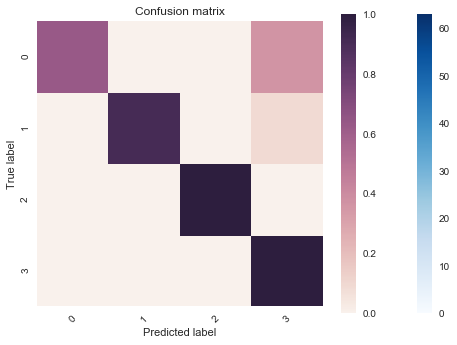

In [380]:
watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 50
bst = xgb.train(param, xg_train, num_round, watchlist)
# get prediction
pred = bst.predict(xg_test)
error_rate = np.sum(pred != test_Y) / test_Y.shape[0]
print('Test error using softmax = {}'.format(error_rate))

# do the same thing again, but output probabilities
param['objective'] = 'multi:softprob'
bst = xgb.train(param, xg_train, num_round, watchlist)
# Note: this convention has been changed since xgboost-unity
# get prediction, this is in 1D array, need reshape to (ndata, nclass)
pred_prob = bst.predict(xg_test)#.reshape(np.array(test_labels).shape[0], 6)
pred_label = np.argmax(pred_prob, axis=1)
error_rate = np.sum(pred != test_labels) / np.array(test_labels).shape[0]
print('Test error using softprob = {}'.format(error_rate))
print(pred_label)
plot_confusion_matrix(confusion_matrix(test_nums,pred_label),classes=[1,2,3,4],normalize=True)

In [350]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

In [351]:
rdf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state = 12)
_ = rdf.fit(train_vecs, train_nums)
np.mean(rdf.predict(test_vecs) == test_nums)

0.8910891089108911

In [352]:
param_grid = {'max_depth': np.arange(3, 10)}

tree = GridSearchCV(DecisionTreeClassifier(random_state = 42, class_weight = 'balanced'), param_grid)

tree.fit(train_vecs, train_nums)
tree_preds = (tree.predict(test_vecs))
np.mean(tree_preds == test_nums)

0.72277227722772275

In [397]:
model.most_similar('smoking') 

[('pcaer', 0.3627100884914398),
 ('desaturation', 0.3546023368835449),
 ('pool', 0.3419247269630432),
 ('girth', 0.3371128439903259),
 ('divere', 0.3255652189254761),
 ('locally', 0.32143813371658325),
 ('pop', 0.320972740650177),
 ('echo', 0.31969547271728516),
 ('ob', 0.31894415616989136),
 ('lishe', 0.3113552927970886)]